# DQN
## To see the result, run the following code and then press Enter to display the output. It may take up to 2 minutes. Thank you in advance for your patience

EP20: 993.4000000000002
EP40: 1025.1000000000001
EP60: 975.7000000000003
EP80: 986.6000000000001
EP100: 969.8000000000001
EP120: 1006.0000000000001
EP140: 942.7
EP160: 1077.9
EP180: 987.4000000000002
EP200: 1044.4000000000003
EP220: 1048.3000000000002
EP240: 1019.8000000000001
EP260: 1011.4000000000001
EP280: 1102.8000000000002
EP300: 1143.3000000000002
EP320: 1195.1000000000001
EP340: 1091.2000000000003
EP360: 1047.2000000000003
EP380: 1183.1000000000001
EP400: 1215.5
EP420: 1224.5000000000002
EP440: 1270.4000000000005
EP460: 1296.4
EP480: 1298.1000000000001
EP500: 1240.6000000000001
EP520: 1308.3000000000002
EP540: 1367.5000000000002
EP560: 1327.0
EP580: 1361.2
EP600: 1257.1000000000001
EP620: 1467.1000000000001
EP640: 1396.2000000000003
EP660: 1438.5000000000005
EP680: 1453.1000000000001
EP700: 1389.8000000000002
EP720: 1418.7000000000003
EP740: 1488.3999999999999
EP760: 1488.0
EP780: 1547.1
EP800: 1559.2
EP820: 1554.9000000000003
EP840: 1557.2000000000003
EP860: 1542.0000000000002


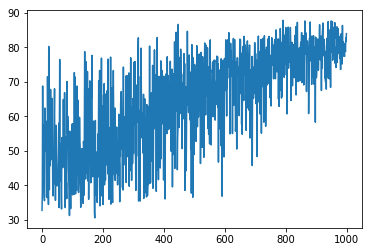

press a key to continue for test run


In [4]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import gym
from numpy.random import choice
import random
import time

N_POS = 150
N_VEL = 120

VALUE_STEP_SIZE = 1e-2  # faster than policy
POLICY_STEP_SIZE = 1e-3

NUM_EPISODES = 1000
GAMMA = 0.999
TEMPERATURE = 1000
EPSILON = 1


ACTIONS = [-1, 0, 1]

class DiscreteSoftmaxPolicy(object):
    def __init__(self, num_states, num_actions, temperature, epsilon):
        self.num_states = num_states
        self.num_actions = num_actions

        self.temperature = temperature
        self.init_temperature = temperature
        self.terminal_temperature = 0.5

        self.epsilon = epsilon
        self.init_epsilon = epsilon
        self.min_epsilon = 0.1

        # initial weights of the policy are zeros
        self.weights = np.zeros((self.num_states, self.num_actions))

    def act(self, state, is_test=False):
        """Given the state, performs an action using epislon-greedy approach and a softmax function.
        This is a discrete policy.

        Args:
            state (List): the list containing the velocity and position of the car
            is_test (bool, optional): Will not randomize actions if this is set to True. Defaults to False.

        Returns:
            [List]: An list containing one element, namely the action value, one of (-1, 0, 1)
        """
        probs = self._action_probs(state)

        if random.random() < self.epsilon:
            action = choice(ACTIONS, p=probs)
        else:
            action = ACTIONS[np.argmax(probs)]
        return [action]

    def _action_probs(self, state):
        """Computes the action probability distribution array

        Args:
            state (List): the list containing the velocity and position of the car

        Returns:
            List: list of probability, each corresponding to an action in the ACTIONS array
        """
        vals = np.exp(self.weights[state] -
                      max(self.weights[state])) / self.temperature
        return vals/np.sum(vals)

    def compute_gradient(self, state, action, advantage):
        """ Computes the gradient of the discounted return at a specific state and action use
        the computed advantage function appropriately.

        Args:
            state (List): the list containing the velocity and position of the car in (N_POS, N_VEL) dimension
            action (List): 
            advantage ([type]): [description]

        Returns:
            [Numpy.Array]: (self.num_states, self.num_actions)
        """
        grad = np.zeros((self.num_states, self.num_actions))
        probs = self._action_probs(state)

        for i, a in enumerate(ACTIONS):
            if a == action:
                grad[state][i] = (1 - probs[i]) / self.temperature * advantage
            else:
                grad[state][i] = (- probs[i]) / self.temperature * advantage

        return grad

    def gradient_step(self, grad, step_size):
        """Takes a step of gradient ascent given a gradient (from compute_gradient()) and a step size. adjust self.weights

        Args:
            grad (list): the list containing gradients for the weights
            step_size (float): the step size in which to update the weights
        """
        self.weights = self.weights + grad * step_size

    def transform_state(self, state):
        """Transform the continuous state into a discrete state

        Args:
            state (list): the list containing the velocity and position of the car

        Returns:
            [list]: the list containing the velocity and position of the car in (N_POS, N_VEL) dimension
        """
        min_position = -1.2
        max_position = 0.6
        max_speed = 0.07
        LOW_STATE = np.array([min_position, -max_speed])
        HIGH_STATE = np.array([max_position, max_speed])

        # Finds the corresponding discrete bucket for the given state
        position, velocity = state[0], state[1]
        state = np.array([0] * 2)
        state[0] = int((position - LOW_STATE[0]) /
                       (HIGH_STATE[0] - LOW_STATE[0]) * (N_POS - 1))
        state[1] = int((velocity - LOW_STATE[1]) /
                       (HIGH_STATE[1] - LOW_STATE[1]) * (N_VEL - 1))

        result = state[0] * N_VEL + state[1]

        return result

class ValueEstimator(object):
    def __init__(self, num_states, num_actions):
        self.num_states = num_states
        self.num_actions = num_actions

        # initial value estimates or weights of the value estimator are set to zero.
        self.values = np.zeros((self.num_states))

    def predict(self, state):
        """ Takes in a state and predicts a value for the state

        Args:
            state (list): the list containing the velocity and position of the car in (N_POS, N_VEL) dimension

        Returns:
            [float]: the estimated values for the given state
        """
        return self.values[state]

    def update(self, state, value_estimate, target, value_step_size):
        """ Construct a suitable loss function and use it to update the values of the value estimator. 
        choose suitable step size for updating the value estimator

        Args:
            state (list): the list containing the velocity and position of the car in (N_POS, N_VEL) dimension
            value_estimate (list): the list containing the value estimate for the given state
            target (list): the list containing the target values for which we will compute the advantage
            value_step_size (float): the factor in which we update the state-values
        """
        advantage = target - value_estimate
        grad_baseline = value_step_size * advantage # with baseline
        self.values[state] += grad_baseline

def get_discounted_returns(rewards, gamma):
    """
        Takes in a list of rewards from an episode
        and returns a list of discounted rewards
        Ex. get_discounted_returns([1, 1, 1], 0.5)
        should return [1.75, 1.5, 1]
    """
    cumulative_returns = np.zeros((len(rewards), ))
    future_returns = 0
    for i in range(len(rewards) - 1, -1, -1):
        cumulative_returns[i] = rewards[i] + gamma * future_returns
        future_returns = cumulative_returns[i]
    return cumulative_returns


def reinforce(env, policy, value_estimator):
    """ This will train the agent given the environment, policy and value estimator.
        Internally, it will compute the baseline, advtange and use those to 
        perform the weight updates to the policy

    Args:
        env ([gym.env]): OpenAI Gym Environment
        policy (DiscreteSoftmaxPolicy): The policy that will be trained
        value_estimator (ValueEstimator): The value estimator instance that's used to compute/update/estimate state-value pairs

    Returns:
        [float]: total rewards for the given training instance (for all NUM_EPISODES)
    """
    total_rewards = []

    state = env.reset()

    for ep in range(NUM_EPISODES):

        # Decrease temperature overtime, to support the epsilon-greedy approach
        policy.temperature -= ((policy.init_temperature -
                                policy.terminal_temperature) / NUM_EPISODES)
        rewards = []
        states = []
        actions = []
        done = False
        policy.epsilon -= (policy.init_epsilon -
                           policy.min_epsilon) / NUM_EPISODES

        # Generate a full episode folowing the policy
        while not done:
            state = policy.transform_state(state)
            states.append(state)

            action = policy.act(state)
            actions.append(action[0])

            state, reward, done, _ = env.step(action)

            # print('State: {} | Action: {}'.format(state, action))
            if done and reward <= 0:
                states = []
                actions = []
                rewards = []
                done = False
                state = env.reset()
            else:
                rewards.append(reward)

        state = env.reset()

        G = get_discounted_returns(rewards, GAMMA)

        # loop through each episode and train the agent
        for i in range(len(states)):
            value = value_estimator.predict(states[i])
            advantage = G[i] - value
            value_estimator.update(states[i], value, G[i], VALUE_STEP_SIZE)
            grad = policy.compute_gradient(states[i], actions[i], advantage)
            policy.gradient_step(grad, POLICY_STEP_SIZE)
        total_rewards.append(np.sum(rewards))
        if ep >= 20 and ep % 20 == 0:
            print('EP{}: {}'.format(ep, np.sum(total_rewards[-20:])))
    
    print('Min: {} | Max: {}'.format(
        np.min(total_rewards), np.max(total_rewards)))

    return total_rewards


if __name__ == "__main__":
    start_time = time.time()
    env = gym.make('MountainCarContinuous-v0')
    env.reset()
    num_actions = len(ACTIONS)
    num_states = N_POS * N_VEL

    policy = DiscreteSoftmaxPolicy(num_states, num_actions,
                                   temperature=TEMPERATURE, epsilon=EPSILON)
    value_estimator = ValueEstimator(num_states, num_actions)
    total_mean_return = reinforce(env, policy, value_estimator)

    print(f'Training took: {(time.time() - start_time):.2f} seconds')
    
    # Data Visualization
    plt.plot(total_mean_return)
    plt.show()

    # Test time
    state = env.reset()
    done = False
    input('press a key to continue for test run')
    while not done:
        state = policy.transform_state(state)
        action = policy.act(state)
        state, reward, done, _ = env.step(action)
        env.render()
    env.close()


In [5]:
# Test time
state = env.reset()
done = False
input('press a key to continue for test run')
while not done:
    state = policy.transform_state(state)
    action = policy.act(state)
    state, reward, done, _ = env.step(action)
    env.render()
env.close()


press a key to continue for test run
